# Application du bruit de Perlin : Champ vec / Art numérique et Optimisation

**Objectif:** Générer un bruit plus complexe et original en partant d'un bruit de Perlin.

**Idée:** On utilise les valeurs du bruit de **Perlin** comme **angles**(donc des valeurs compris dans (0,$2\pi$)) dans un champ vectoriel donc où un **vecteur de l'espace** sera : $\vec{u}(x,y) = (cos(\theta(x,y)),sin(\theta(x,y)))$ où $\theta$ est simplement notre bruit de Perlin rapporté sur 0:2pi. Ensuite on dessine la **trajectoire de particules** influencées par le champ.

**Plan:**

1. Prérequis $\\[0 cm]$
    - Rappel du bruit de **Perlin**
    - Bar de chargement $\\[0 cm]$
2. Premier visuel / **Idée** générale $\\[0 cm]$
3. **Génération** du bruit $\\[0 cm]$
4. **Manipulation** du bruit $\\[0 cm]$
    - 2D
    - 3D $\\[0 cm]$
5. **Optimisations** possibles pour gagner en temps de rendu $\\[0 cm]$
    - MultiProcessing (CPU)
    - QuadTree
    - Utilisation du GPU $\\[0 cm]$
6. Conclusion

## Prérequis / Rappel : Génération du bruit de Perlin

On génère notre bruit de Perlin, pour le rappel et éviter de regarder entre plusieurs fichiers voici le code:

In [1]:
%%writefile perlin2D.py
import numpy as np

class Perlin2D():
    
    #Shape : [sx,sy] où sx et sy sont la taille de la matrice
    #Res : [rx,ry] où sx est multiple de rx, et rx = la résolution/fréquence primaire sur x,
            #c'est à dire si rx augmente alors on calcule une plus grande zone de notre bruit (même idée sur y)
    def __init__(self,shape,res):
        self.shape = shape
        self.res = res
        #Matrice aléatoire qui donne le côté aléatoire au bruit vu qu'elle sera différente pour tous les instances
            #de l'objet perlin2D.
        self.random_numpy = np.random.rand(res[0]+1, res[1]+1)
        
        self.noise = self.perlin2D()
        
    def lerp(self, t):
        return 6*t**5 - 15*t**4 + 10*t**3
    
    def regenRdmNoise(self):
        self.random_numpy = np.random.rand(int(self.res[0])+1, int(self.res[1])+1)
    
    #Gen le bruit de Perlin en 2D
    def perlin2D(self):
        shape = self.shape
        res = self.res
        lerp = self.lerp

        #basé sur https://weber.itn.liu.se/~stegu/simplexnoise/simplexnoise.pdf ; https://fr.wikipedia.org/wiki/Bruit_de_Perlin
        delta = (res[0] / shape[0], res[1] / shape[1])
        d = (shape[0] // res[0], shape[1] // res[1])
        
        #On définit la grille sur laquelle on va travailler, en effet res<shape donc on créer les coordonnées dans les 
        #dans les intervalles entre les points de la matrice aléatoire(de taille res).
        grid = np.mgrid[0:res[0]:delta[0],0:res[1]:delta[1]].transpose(1, 2, 0) % 1
        
        #Le bruit de Perlin est basé sur l'utilisation des gradients et tout son intérêt provient de cette opératon
        #appliquée sur la matrice aléatoire
        random_numpy = self.random_numpy
        angles = 2*np.pi*random_numpy[0:res[0]+1, 0:res[1]+1]
        gradients = np.dstack((np.cos(angles), np.sin(angles)))
        g00 = gradients[0:-1,0:-1].repeat(d[0], 0).repeat(d[1], 1)
        g10 = gradients[1:,0:-1].repeat(d[0], 0).repeat(d[1], 1)
        g01 = gradients[0:-1,1:].repeat(d[0], 0).repeat(d[1], 1)
        g11 = gradients[1:,1:].repeat(d[0], 0).repeat(d[1], 1)
        
        #Par la suite on l'applique à la grille en faisant des produits scalaires/rampes.
        n00 = np.sum(grid * g00, 2)
        n10 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1])) * g10, 2)
        n01 = np.sum(np.dstack((grid[:,:,0], grid[:,:,1]-1)) * g01, 2)
        n11 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]-1)) * g11, 2)
        
        #On applique un procédé d'interpolation sur la grille (procédé défini dans le doc de Perlin)
        t = lerp(grid)
        n0 = n00*(1-t[:,:,0]) + t[:,:,0]*n10
        n1 = n01*(1-t[:,:,0]) + t[:,:,0]*n11
        
        #On normalise le bruit pour qu'il soit entre 0 et 1(pour faciliter la manipulation)
        return (np.sqrt(2)*((1-t[:,:,1])*n0 + t[:,:,1]*n1) + 1)/2
    
    #Gen le bruit fractal
    def fractal2D(self, octaves=1, persistance=0.5, exponentiation=1, lacunarity=1, norm=True):
        shape = self.shape
        res = self.res
        noise = np.zeros([int(shape[0]),int(shape[1])])
        
        frequency = 1
        amplitude = 1
        
        #Comparable à une série de Fourier, on ajoute plusieurs octaves/bruits avec une fréquence et amplitude
            #multipliées pour chaque itération de la série. = On rajoute du "détail" au bruit
        for _ in range(octaves):
            res = [frequency * res[0], frequency * res[1]]
            self.res = res
            self.regenRdmNoise()
            noise += amplitude * self.perlin2D()
            frequency *= lacunarity
            amplitude *= persistance
        
        noise = noise**exponentiation
        
        #On normalise pour être certain qu'il soit entre 0 et 1
        return noise/noise.max() if(norm) else noise

Writing perlin2D.py


En supplément, on développe une fonction pour montrer la progression du calcul dans la console afin d'avoir une estimation du temps que ça va prendre (vu que ça peut facilement être plusieurs heures).

In [3]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    if iteration == total: 
        print()

## Premier visuel

On développe deux objets : 
- Un pour une particule qui sera simulée dans notre espace, influencée par le champ vectoriel généré via le bruit de Perlin. 
- Un autre pour avoir les informations de la simulation dans sa globalité.

On peut déjà faire quelques essais (temps rendu long).

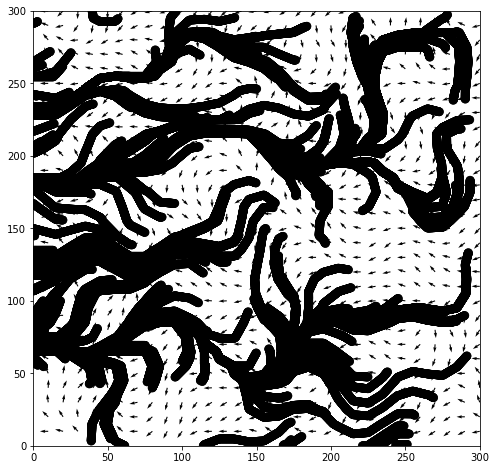

In [29]:
from matplotlib import animation, rc
rc('animation', html='jshtml')
import random
import matplotlib.pyplot as plt

#Grille de {shape} points de longueur avec {shape/delta} vecteurs sur une ligne. Exemples générés donc avec 30*30 vecteurs.
shape = 300.0
delta = 10.0

#On génère le bruit
noise = Perlin2D([shape/10,shape/10],[5,5]).noise

#On génère le champ via le bruit de Perlin, une méthode est d'utiliser la valeur du bruit de Perlin comme un angle.
field = []
for i in range(len(noise)):
    for j in range(len(noise[i])):
        field.append((np.cos(noise[i][j] * (2*np.pi)),np.sin(noise[i][j] * (2*np.pi))))
field = np.asarray(field)

#On transforme tout en des variables utilisables par matplotlib
X,Y = np.mgrid[delta:shape+delta:delta, delta:shape+delta:delta]
U=np.array([field[i][0] for i in range(len(field))]).reshape((int(shape/delta), int(shape/delta)))
V=np.array([field[i][1] for i in range(len(field))]).reshape((int(shape/delta), int(shape/delta)))

fig, ax = plt.subplots(figsize=(8,8))

#On crée notre objet particule
class Particle2D():
    #plot : [X,Y,U,V]
    def __init__(self,ax, mass, pos, plot, friction=0.5, color="red"):
        
        #A chaque itération du temps on va dessiner un cercle sur le plot
        self.c = plt.Circle((pos[0],pos[1]), 2, facecolor=color)
        self.iteration = 0
        self.color = color
        self.pos = pos
        self.mass = mass
        self.plot = plot
        #La particule perd un pourcentage de sa vitesse par itération du temps
        self.friction = friction
        #vitesse de la particule
        self.v = np.asarray([0,0])
        
        #pour dessiner le cercle
        ax.add_patch(self.c)
        
    #On update les propriétés de la particule à chaque dt
    def update(self,dt,t,time):
        #On redessine un cercle
        ax.add_patch(plt.Circle((self.pos[0],self.pos[1]), 3, facecolor=self.color))
        #On update la position
        self.pos += self.v * dt
        
        #Si la particule est sorti de l'espace: on termine son calcul de trajectoire
        if(self.pos[0] > shape or self.pos[0] < 0 or self.pos[1] > shape or self.pos[1] < 0):
            return True
        
        self.c.center = [self.pos[0],self.pos[1]]
        
        #La particule perd de la vitesse car frottement
        self.v = np.asarray((self.v[0] *self.friction,self.v[1] *self.friction))
        #On récupère le vecteur de Perlin le plus proche
        vec = self.getClosestVector()
        #Le vecteur est une force nous donnant une accélération
        self.v = np.asarray([(1/self.mass) * vec[0],(1/self.mass) * vec[1]])
        return False
    
    #Méthode pour avoir le plus proche vecteur d'une particule
    def getClosestVector(self):
        X,Y,U,V = self.plot
        mini = [X.max(),Y.max()]
        vec = (0,0)
        #double boucle for classique(approche naive/couteuse) pour itérer sur un espace
        for i in range(len(X)):
            for j in range(len(Y)):
                x = X[i][0]
                y = Y[0][j]
                if(np.abs(x-self.pos[0]) <= mini[0] and np.abs(y-self.pos[1]) <= mini[1]):
                    mini[0] = np.abs(x-self.pos[0])
                    mini[1] = np.abs(y-self.pos[1])
                    vec = (U[j][i],V[j][i])
        return vec
    #Si jamais on veut vérifier que le vecteur est bien le bon
    def getAbsoluteVecPos(self,vec,U,V):
        for i in range(len(U)):
            for j in range(len(V)):
                if(U[j][i] == vec[0] and V[j][i] == vec[1]):
                    return (i*delta,j*delta)
    
#On crée l'objet global qui contiendra les particules
class SimulationPlot():
    def __init__(self,number,ax,shape,X,Y,U,V):
        self.particles = []
        for i in range(number):
            #On ajoute autant de particules demandées avec position aléatoire
            self.particles.append(Particle2D(ax,1,np.array([random.random()*shape,random.random()*shape]),(X,Y,U,V),color=(0,0,0,0.5)))
    
    #On update la simulation tt les dt
    def update(self,dt,t,time):
        #Bar de progression pour suivre le rendu
        printProgressBar(t, time/dt, prefix = 'Progress:', suffix = 'Complete', length = 50)
        temp_part = []
        #Si la particule n'est pas sorti on continue de l'update sinon on la supprime de la liste des particules à itérer.
        for p in self.particles:
            if(not(p.update(dt,t,time))):
                temp_part.append(p)
        self.particles = temp_part
        
    #Pour lancer la simulation
    def simulate(self, ax, time, dt):
        for t in range(int(time/dt)):
            self.update(dt,t,time)

#On crée notre objet avec les paramètres
s = SimulationPlot(200,ax,shape,X,Y,U,V)

ax.axis([0, shape, 0, shape])

#On dessine le champ vectoriel pour avoir un aperçu
q = ax.quiver(X, Y, U, V)

#On lance la simulation
s.simulate(ax,500,0.1)

#On rend le résultat
plt.show()
#animation.FuncAnimation(fig, lambda p: s.update(.5,p,200), frames=200, interval=50)



Le résultat a l'air d'être quelques choses de très visuel / de très "fluide", parfait... Maintenant on veut générer ça sur tout l'espace et pas d'une seule couleur mais sur une color map (discret à "continu"). 

## Génération de notre nouveau bruit

Pour cela on va séparer l'espace en grille défini via une variable résolution puis dans chaque cellule de la grille on va simuler la trajectoire d'une particule partant du centre de celle-ci. Or à la place de dessiner directement la trajectoire on va augmenter une variable (de 0 à 1) compris dans une matrice correspondant à l'espace. C'est à dire que chaque position dans l'espace aura une valeur associée compris entre 0 et 1 à la fin. On dessinera ensuite cette matrice via matplotlib. (Cette matrice possède donc les mêmes propriétés d'un noise et est donc un "nouveau" bruit qu'on peut utiliser pour d'autres applications...).

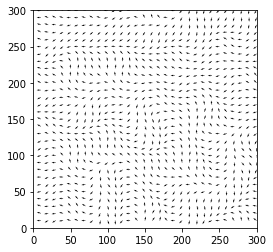

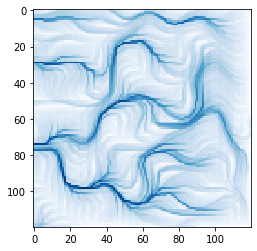

In [4]:
#Même chose que précedemment mais on crée une particule par cellule de la grille défini par notre {shape} et {delta2}. 
#Et cette fois-ci à la place de dessiner un cercle on augmente la valeur d'un élement d'une matrice qui correspond à notre espace
import numpy as np
import matplotlib.pyplot as plt

shape = 300.0
delta = 10.0

noise = Perlin2D([shape/10,shape/10],[5,5]).noise
field = []
for i in range(len(noise)):
    for j in range(len(noise[i])):
        field.append((np.cos(noise[i][j] * (2*np.pi)),np.sin(noise[i][j] * (2*np.pi))))
field = np.asarray(field)

X,Y = np.mgrid[delta:shape+delta:delta, delta:shape+delta:delta]
U=np.array([field[i][0] for i in range(len(field))]).reshape((int(shape/delta), int(shape/delta)))
V=np.array([field[i][1] for i in range(len(field))]).reshape((int(shape/delta), int(shape/delta)))

fig, ax = plt.subplots(figsize=(4,4))

ax.axis([0, shape, 0, shape])

q = ax.quiver(X, Y, U, V)
plt.show()

class Particle2D():
    #plot : [X,Y,U,V]
    def __init__(self, res, mass, pos, plot, friction=0.5):
        
        self.iteration = 0
        self.pos = pos
        self.mass = mass
        self.plot = plot
        self.friction = friction
        self.v = np.asarray([0,0])
        
        #On crée la matrice de l'espace pour cette particule (Inutile ici: pour du single thread)
        self.M = np.zeros((int(shape/res),int(shape/res)))
        
    def simulate(self, time, dt, incr):
        for t in range(int(time/dt)):
            flag, self.M = self.update(self.M,incr,dt,t,time)
            
        
        
    def update(self,M,incr,dt,t,time): 
        #On incrémente la variable correspond à la position de la particule dans la matrice globale
        M[int(self.pos[1] * len(M) / shape)][int(self.pos[0] * len(M[0]) / shape)] += incr
        
        self.pos += self.v * dt
        
        if(self.pos[0] > shape or self.pos[0] < 0 or self.pos[1] > shape or self.pos[1] < 0):
            return (True, M)
        
        self.v = np.asarray((self.v[0] *self.friction,self.v[1] *self.friction))
        vec = self.getClosestVector()
        self.v = np.asarray([(1/self.mass) * vec[0],(1/self.mass) * vec[1]])
        #On retourne en + la matrice
        return (False, M)
    
    def getClosestVector(self):
        X,Y,U,V,X2,Y2 = self.plot
        mini = [X.max(),Y.max()]
        vec = (0,0)
        for i in range(len(X)):
            for j in range(len(Y)):
                x = X[i][0]
                y = Y[0][j]
                if(np.abs(x-self.pos[0]) <= mini[0] and np.abs(y-self.pos[1]) <= mini[1]):
                    mini[0] = np.abs(x-self.pos[0])
                    mini[1] = np.abs(y-self.pos[1])
                    vec = (U[j][i],V[j][i])
        return vec
    def getAbsoluteVecPos(self,vec,U,V):
        for i in range(len(U)):
            for j in range(len(V)):
                if(U[j][i] == vec[0] and V[j][i] == vec[1]):
                    return (i*delta,j*delta)
    
    

class SimulationPlot():
    def __init__(self,res,shape,X,Y,U,V):
        
        #Matrice de l'espace
        self.M = np.zeros((int(shape/res),int(shape/res)))
        
        self.particles = []
        X2,Y2 = np.mgrid[res:shape+res:res, res:shape+res:res]
        
        for i in range(int(shape/res)):
            for j in range(int(shape/res)):
                self.particles.append(Particle2D(res,1,np.array([i*res,j*res]),(X,Y,U,V,X2,Y2)))

    def update(self,incr,dt,t,time):
        printProgressBar(t, time/dt, prefix = 'Progress:', suffix = 'Complete', length = 50)
        temp_part = []
        for p in self.particles:
            #On récupère la matrice modifiée
            flag, self.M = p.update(self.M,incr,dt,t,time)
            if(not(flag)):
                temp_part.append(p)
        self.particles = temp_part
    def simulate(self, border, time, dt, incr):
        for t in range(int(time/dt)):
            self.update(incr,dt,t,time)
        
        #On return la matrice finale normalisée et avec un log ainsi qu'une limite supérieur afin de faire ressortir
        #les valeurs basses (car sinon les hautes valeurs "cachent" les plus faibles)
        return np.array(list(map(lambda i: list(map(lambda j: j if j <= border else border ,i)),np.log(self.M+1)/self.M.max())))

delta = 2.5
s = SimulationPlot(delta,shape,X,Y,U,V)
result = s.simulate(0.1,100,0.5, 0.025)
#On peut appliquer de l'interpolation via matplotlib, par exemple : quadric, pour, quelques fois, augmenter la qualité.
plt.imshow(result, cmap="Blues", interpolation='None')
plt.show()


In [8]:
#Si on veut enregistrer le rendu dans un fichier

#import numpy as np

#with open("Perlin_Vec1.npy",'wb') as f:
#   np.save(f, result)

#NE PAS REUTILISER / FICHIER QUI COMPREND UN RENDU DE 1H30 (10k particules / sans multiprocessing(avec multiprocessing sur jupyter uga:15mins))

## Manipulation du bruit

Maintenant qu'on a notre résultat, on peut lui appliquer quelques opérations pour le rendre plus visuel (dans notre cas) ou alors plus utilisable en lui appliquant une interpolation par exemple.
Dans notre cas on va lui appliquer un "ridge" c'est à dire: $-1 * |n(x,y)| + 1$ afin de marquer le relief. On lui a déjà appliqué à la fin du rendu un log() afin de faire ressortir les "courants" du fond.

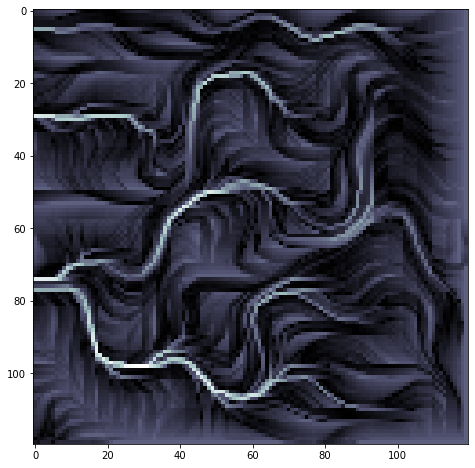

In [66]:
#On charge le rendu prégénéré lors d'une session précedente
with open('Perlin_Vec1.npy', 'rb') as f:
    result = np.load(f)

#Traitement de l'image

fig, ax = plt.subplots(figsize=(8,8))
#Même si, normalement, le bruit est déjà normalisé rien n'empêche de renormaliser pour être certain de ce qu'on manipule.
result = result / result.max()
#On applique un ridge car on explore les possibilités visuels du bruit
result = -1 * np.abs(result-0.3) + 1
#On applique une palette de couleur
ax.imshow(result, cmap="bone_r", interpolation='None')


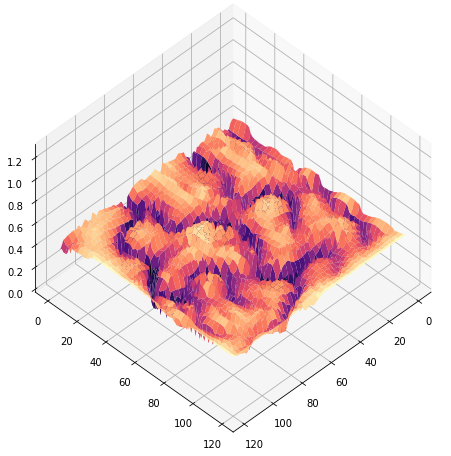

In [128]:
#Pourquoi on ne le rendrait-il pas en 3D ?

#Si jamais on ne lance que cette cellule de code, on le recharge
with open('Perlin_Vec1.npy', 'rb') as f:
    result = np.load(f)

#Modifications empiriques
def f(x, y):
    return np.zeros([int(120),int(120)]) + (-result*10+0.5)
  
X, Y = np.mgrid[0:120, 0:120]

fig = plt.figure(figsize = (6,6))
ax = plt.axes(projection ='3d')
ax.set_proj_type('ortho')
ax.view_init(45, 45)
ax.set_zlim3d(0,1.3)
ax.plot_surface(X, Y, f(X, Y), cmap="magma",linewidth=0, antialiased=True)

## Optimisation du temps de rendu/de calcul pour utilisations concrètes
### - Introduction au MultiProcessing

Le rendu plus haut a pris **1h30** à rendre en faisant les instructions linéairements (comme une seule grande tâche). Or sur Python (et sur la majorité des autres languages de programmations) il est possible de "découper" cette grande tâche et calculer simultanément plusieurs petites taches en même temps. 
Il ne faut pas confondre le **MultiThreading et le MultiProcessing**. En effet imaginons que nous voulons calculer deux taches T1 et T2 avec des threads : le CPU va calculer un bout de la tache T1 puis un bout de la tache T2 et ainsi de suite. Ce n'est donc pas du simultané. C'est utile pour des intéractions I/O mais pas pour du calcul pur et simple. 
C'est pour cela que nous passons par du MultiProcessing, à la place de créer des Threads sur un même core du CPU (donc une même unité de calcul) nous divisons la tâche principale en plusieurs petites tâches que nous allons attribuer à chaque core du CPU. (En général 4-8 cores pour un PC "normal", 16-32 pour des VPS (virtual private server - hébergeur (comme sur jupyter) or ces cores ont une puissance de calcul divisé par le nombre de sessions/nombre d'utilisateurs sur le même VPS).
Ainsi chaque core va faire une tâche (ici la trajectoire d'une seule particule à la place de tt les particules) et dès qu'il a fini sa tâche on lui réattribue une autre particule et ainsi de suite jusqu'à à avoir tt calculer. Pour rassembler les résultats, il suffit d'additionner les matrices des trajectoires pour en obtenir une seule.
On passe donc de **1h30 de rendu à 10 minutes** de rendu en utilisant **10 cores**, pour une même résolution.

(PS: On pourrait aussi utiliser le GPU qui est fait pour faire des tâches répétitives plus rapidement(des milliers de cores de + faible puissance). En gros GPU >> CPU quand le nombre de données augmente)

Néanmoins on est limité par le nombre de particules donc notre résolution mais ce n'est pas un soucis de temps de calcul (la taille de la liste des particules est trop grande).

*(Voir le fichier associé à celui-ci/ dédié au calcul)*

**Ce qu'on a rajouté (ce qui est important) dans le code:**

In [1]:
#Pour savoir le nombre de cores disponibles sur le serveur
import os
print(os.cpu_count())

32


In [ ]:
import multiprocessing

#On crée notre manager
manager = multiprocessing.Manager()
        
        #Le nombre de particules > au nombre de cores du CPU donc on divise en plusieurs étapes
        for i in range(math.ceil(len(self.particles) / NUM_PROC)):
            
            #Afin de partager la matrice entre les "threads" il faut qu'on utilise une variable instanciée qui ne change pas en fonction d'où on y accède, faut juste faire attention à ne pas utiliser la même variable pour 2 process qui s'éxecutent en même temps si ils sont synchrones. Donc DATA = dico de tt les matrices de pos de chaque particule qui sont éxecutées en même temps.
            DATA = manager.dict()
            
            #jobs = les threads en cours
            jobs = []
            for k in range(NUM_PROC):
                if(i * NUM_PROC + k < len(self.particles)):
                    #On crée le process
                    process = multiprocessing.Process(
                        target=self.particles[i*NUM_PROC+k].simulate, 
                        args=(i * NUM_PROC + k,DATA,time,dt,incr)
                    )
                    jobs.append(process)
            #On les lance
            for j in jobs:
                j.start()
            
            #join() = on attend la fin du process pour revenir au main thread et donc continuer après = on attend tous les process pour continuer.
            #Une optimisation serait de ne pas attendre tous les process pour en relance mais dès qu'il y a une place on relance directement.
            for j in jobs:
                j.join()
            
            #Bar de progression
            printProgressBar(i, math.ceil(len(self.particles) / NUM_PROC), prefix = 'Progress:', suffix = 'Complete', length = 50)
            
            #On additionne les matrices de positions obtenus avec celle globale.
            for m in DATA.values():
                self.M = self.M + m

### - QuadTree / Subdivision par une grille (ou plusieurs grilles (grille contenant une grille))
(Optimisation possible pour le calcul d'un bruit de Worley; Passer d'une simulation de gravitation de 1k particules à 100k-1M(en temps réel); fluide etc etc)

Exemple pour **simulateur de gravitation**: on subdivise notre plan en une grille, on calcule les forces entre les particules d'une seule cellule, on fait une moyenne empire/ou gradient et on applique cette intéraction moyenne aux autres cellules. Donc on peut subdiviser autant qu'on veut avec des grilles de taille différente. (PS le nombre d'opérations nécessaires pour une approche naïve d'un simulateur de ce type est de n² où n est le nombre de particules (car double boucle for (pour tt les particules on calcule la force de tt les particules sur celle de la première boucle) ).
Avec ça on peut par exemple simuler la formation d'un système planétaire(avec collisions entre proto-planètes...), formation/collision de galaxies, expansion de l'Univers après le big bang et observer la forme d'"éponge" de l'Univers !.
Ce n'est pas le projet ici mais c'est un très bon projet à faire pour débuter et très visuel.

Pour ce cas précis le mouvement de nos particules ne dépendent pas les une des autres donc ce n'est pas nécessaire d'utiliser QuadTree. 

### - Via le GPU
Le **GPU contient bien plus de cores qu'un CPU** mais à plus **faible fréquence = moins performant**. En effet le GPU est fait pour calculer des petites tâches répétitives en très grande quantité (d'où son utilisation dans le rendu en général). 
Pour faire du MultiProcessing via le GPU il faudrait un module dont je n'ai pas accès sur jupyter. 


## Conclusion

Avec un peu d'imagination on a obtenu un résultat complètement différent, si on veut on peut aussi rajouter des intéractions entre les particules par exemple, afin d'obtenir un résultat bien différent encore.

Des artistes utilisent cette infinité de possibilités afin de produire de l'art numérique et donc des résultats qui ne sont que purement visuels (c'est à dire pas à but d'être utilisé dans un shader(=effet visuel d'un jeu par exemple)).

Si on voudrait utiliser le résultat qu'on a obtenu pour du terrain par exemple il serait fort intéressant de lerp/interpoler le résultat pour l'adoucir ou d'appliquer d'autres opérations en sortie.